## Training an image classifier from scratch on the Dogs vs Carps dataset.

## Introduction
This is an analysis of data on dogs and carps in order to shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras Application model.


## Setup


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator


## Load the data: the Cats vs Dogs dataset

### Raw data download

First, let's download the zip folder:


In [ ]:
dataset_dir = '/content/pets.zip'
!unzip -q pets.zip



### Filter out corrupted images

First create a PetImages folder which contain two subfolders, cane and carpa. Each subfolder contains image files for each category.

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
 in their header.


In [ ]:
import os

num_skipped = 0
for folder_name in ("cane", "carpa"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 0 images


As we can se there is no corrupted images on our data

## Generate the Train and the Validation datasets
## with data augmentation


In [ ]:
image_size = (180, 180)

datagen = ImageDataGenerator( rescale=1./255,
        rotation_range=3,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image
        width_shift_range=0.01,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.01,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        validation_split=0.2)  # validation split
train_ds = datagen.flow_from_directory(
        "PetImages", target_size=image_size, color_mode='rgb', class_mode='categorical',
         batch_size=64, shuffle=True, seed=13,
        subset='training')
val_ds = datagen.flow_from_directory(
        "PetImages", target_size=image_size, color_mode='rgb', class_mode='categorical',
         batch_size=64, seed=13,
        subset='validation')

Found 1981 images belonging to 2 classes.
Found 494 images belonging to 2 classes.


## Visualize the data

Here are the first 16 images in the training dataset. Label 0 is "dog" and label 1 is "carp".


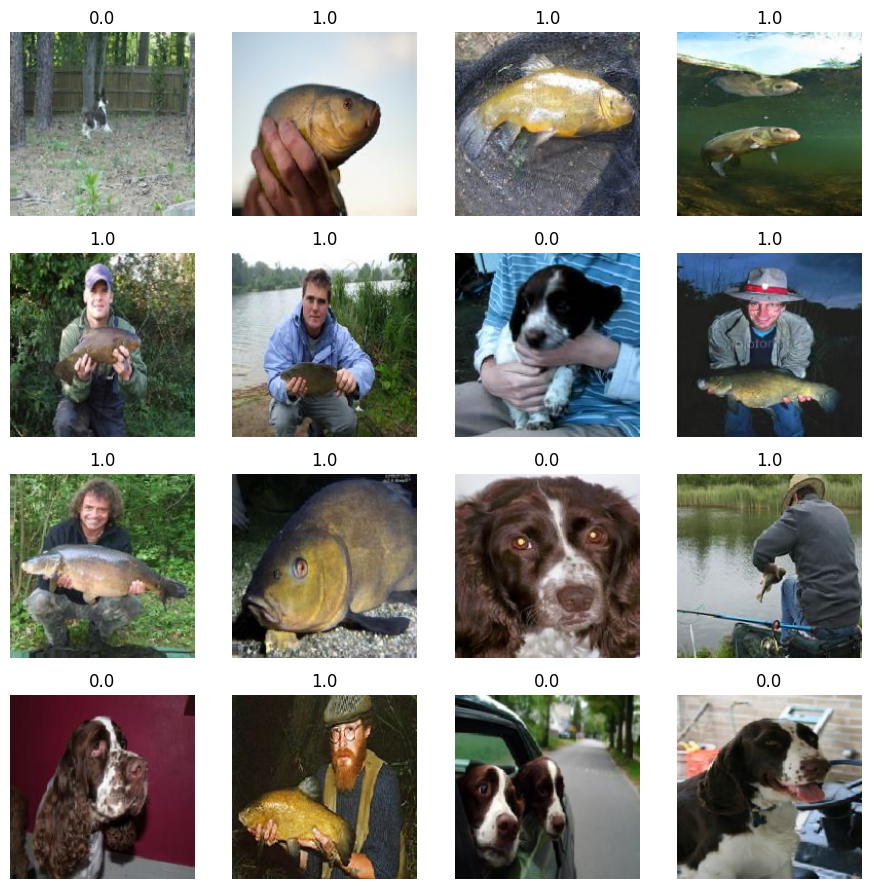

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(11, 11))
images=train_ds[0][0]
labels=train_ds[0][1]
for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].astype("float32"))
#        print(i,labels[i][1])
        plt.title(labels[i][1])
        plt.axis("off")


## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
 configuration, consider using
[Keras Tuner](https://github.com/keras-team/keras-tuner).


In [ ]:
from tensorflow.keras.layers import InputLayer, Input, BatchNormalization
from tensorflow.keras.layers import Reshape, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

inp = Input((180,180,3))
x = Conv2D(32,(5,5),activation='relu',input_shape=(180,180,3))(inp)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)
x = Dropout(0.2)(x)
x = Conv2D(32,(3,3),activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)
x = Dropout(0.2)(x)
x = Conv2D(16,(3,3),activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x= Dense(128,activation='relu')(x)
x= BatchNormalization()(x)
x = Dropout(0.3)(x)
out = Dense(2,activation='softmax')(x)
model = Model(inp,out)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 176, 176, 32)      2432      
                                                                 
 batch_normalization_4 (Bat  (None, 176, 176, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 88, 88, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 88, 88, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 86, 86, 32)        9248

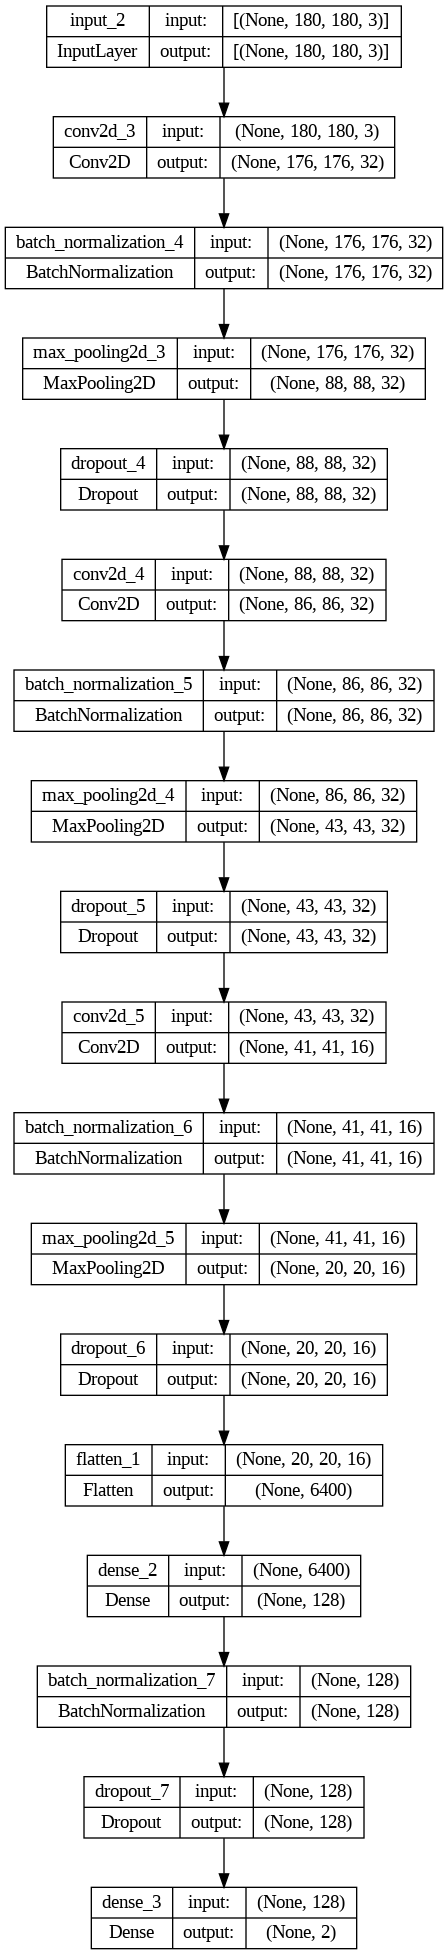

In [ ]:
plot_model(model, show_shapes=True)

## Train the model


In [ ]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
31/31 [==============================] - 32s 922ms/step - loss: 0.6378 - accuracy: 0.7764 - val_loss: 0.6990 - val_accuracy: 0.5344
Epoch 2/10
31/31 [==============================] - 22s 718ms/step - loss: 0.3274 - accuracy: 0.8778 - val_loss: 1.4872 - val_accuracy: 0.5081
Epoch 3/10
31/31 [==============================] - 21s 677ms/step - loss: 0.2695 - accuracy: 0.8990 - val_loss: 0.6021 - val_accuracy: 0.6579
Epoch 4/10
31/31 [==============================] - 22s 722ms/step - loss: 0.2137 - accuracy: 0.9192 - val_loss: 0.6145 - val_accuracy: 0.6660
Epoch 5/10
31/31 [==============================] - 22s 688ms/step - loss: 0.1956 - accuracy: 0.9308 - val_loss: 0.6760 - val_accuracy: 0.6377
Epoch 6/10
31/31 [==============================] - 22s 721ms/step - loss: 0.1849 - accuracy: 0.9263 - val_loss: 0.7330 - val_accuracy: 0.6781
Epoch 7/10
31/31 [==============================] - 22s 691ms/step - loss: 0.1735 - accuracy: 0.9298 - val_loss: 0.8255 - val_accuracy: 0.6640

### We can obtain to >90% validation accuracy


## Run inference on new data





In [ ]:
import numpy as np
img = load_img('/content/cane.JPEG', target_size=(180,180))
A = keras.preprocessing.image.img_to_array(img)/255.
B = A.reshape(1,180,180,3)
my_prediction = model.predict(B)
np.set_printoptions(suppress=True,precision=4)
print("Your algorithm predicts",  my_prediction)


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

img_path = '/content/cane.JPEG'  # Update with the correct path to your image
img = load_img(img_path , target_size=(180, 180))
img_array = img_to_array(img)/255.0
img_batch = np.expand_dims(img_array, axis=0)  # Add a batch dimension

predictions = model.predict(img_batch)
class_index = np.argmax(predictions[0])  # Find index of the class with maximum probability

# Create a mapping from indices to class labels
class_labels = {0: 'dog', 1: 'carp'}

predicted_class = class_labels[class_index]
print("Your algorithm predicts: ", predicted_class)

1/1 [==============================] - 0s 19ms/step
Your algorithm predicts:  dog
